# Siamese Network + SVM with Raw Image

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
import caffe
import os
def load_list(data_dir, prefix = None, dataset = 1):
    train_list = os.path.join(data_dir, 'train') + str(dataset) + '.idx'
    test_list = os.path.join(data_dir, 'test') + str(dataset) + '.idx'
    with open(train_list) as f:
        train_list = f.read().splitlines()
    with open(test_list) as f:
        test_list = f.read().splitlines()
    if prefix is not None:
        train_list = map(lambda x: os.path.join(prefix, x), train_list)
        test_list = map(lambda x: os.path.join(prefix, x), test_list)
    return train_list, test_list

def load_img(filename, flip = False, grayscale = False):
    if grayscale:
        img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    else:
        img = cv2.imread(filename)
    if flip:
        img = cv2.flip(img, 1)
    if grayscale:
        width, height = img.shape
    else:
        width, height, _ = img.shape
    factor = max(256.0 / width, 256.0 / height)
    img = cv2.resize(img, None, fx = factor, fy = factor)
    return img

def load_imgs(filenames, reverse = False, flip = False, grayscale = False):
    if reverse:
        filenames = filenames[::-1]
    imgs = map(lambda x: load_img(x, flip, grayscale), filenames)
    return imgs

def load_video(video, data_dir, mask = None, reverse = False, flip = False, grayscale = False):
    filenames = os.listdir(os.path.join(data_dir, video))
    filenames = filter(lambda x: x[-4:] == 'jpeg', filenames)
    if mask is not None:
        filenames = filter(mask, filenames)
    filenames.sort()
    filenames = map(lambda x: os.path.join(data_dir, video, x), filenames)
    imgs = load_imgs(filenames, reverse, flip, grayscale)
    return imgs

def is_forward(video):
    if video[0] == 'F':
        return True
    return False

def select(imgs, n = 5):
    mags = [None] * (len(imgs)/2)
    for i in range(len(imgs)/2):
        mag, _ = cv2.cartToPolar(np.asarray(imgs[2*i], dtype = np.float32), np.asarray(imgs[2*i+1], dtype = np.float32))
    mags[i] = cv2.norm(mag)
    mags = np.asarray(mags)
    idx = np.argsort(mags)[::-1][:n]
    idx.sort()
    return idx

In [2]:
def load_flows(video, direction):
    imgs_ = load_video(video, './data/ArrowDataAll', 
                               mask = lambda x: x[:3] == 'of' + direction, 
                               grayscale=True)
    imgs_ = map(lambda x: cv2.resize(x, (227, 227)), imgs_)
    return imgs_

In [3]:
# display plots in this notebook
%matplotlib inline
# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

In [4]:
def load_features(video):
    with open(os.path.join('./data/ArrowDataAll', video, 'features1.csv'), 'r') as f:
        X = np.loadtxt(f, delimiter = ',')
    with open(os.path.join('./data/ArrowDataAll', video, 'labels1.csv'), 'r') as f:
        y = np.loadtxt(f, delimiter = ',')
    video_names_with_multitude = [video] * len(y)
    return X, y, video_names_with_multitude

In [5]:
train_list, test_list = load_list('./data', dataset = 1)

In [29]:
X_train = np.empty((0, 4096))
y_train = np.empty(0)
video_train = []
for video in train_list:
    if train_list.index(video) % 10 == 0:
        print train_list.index(video)+1
    X, y, video_names_with_multitude = load_features(video)
    X_train = np.append(X_train, X, axis = 0)
    y_train = np.append(y_train, y, axis = 0)
    video_train.extend(video_names_with_multitude)

1
11
21
31
41
51
61
71
81
91
101
111


In [30]:
X_test = np.empty((0, 4096))
y_test = np.empty(0)
video_test = []
for video in test_list:
    if test_list.index(video) % 10 == 0:
        print test_list.index(video)+1
    X, y, video_names_with_multitude = load_features(video)
    X_test = np.append(X_test, X, axis = 0)
    y_test = np.append(y_test, y, axis = 0)
    video_test.extend(video_names_with_multitude)

1
11
21
31
41
51


In [31]:
import pandas as pd
from pandas import Series, DataFrame
tmp = DataFrame(X_train)
tmp['label'] = Series(y_train)
fold = [['A']*20 + ['B']*20 + ['C']*20 + ['D']*20]*120
import itertools
fold = list(itertools.chain(*fold))
tmp['fold'] = Series(fold)
tmp['video'] = Series(video_train)
tmp=tmp.groupby(['video', 'fold']).mean()


In [35]:
X_train = tmp.drop('label', axis = 1)
y_train = tmp['label']
tmp = DataFrame(X_test)
tmp['label'] = Series(y_test)
fold = [['A']*20 + ['B']*20 + ['C']*20 + ['D']*20]*60
import itertools
fold = list(itertools.chain(*fold))
tmp['fold'] = Series(fold)
tmp['video'] = Series(video_test)
tmp=tmp.groupby(['video', 'fold']).mean()
X_test = tmp.drop('label', axis = 1)
y_test = tmp['label']

In [43]:
from sklearn.svm import SVC
clf = SVC(kernel = 'linear', C = 100)
clf.fit(X_train, y_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [44]:
clf.score(X_test, y_test)

0.47916666666666669

In [151]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_jobs = -1, n_estimators=100, bootstrap=True)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [152]:
print clf.score(X_test, y_test)

0.521041666667


In [153]:
y_predict = clf.predict(X_test)

In [154]:
import pandas as pd
from pandas import Series, DataFrame

In [155]:
df = DataFrame(Series(y_test))

In [156]:
df[1] = Series(y_predict)
df[2] = Series(video_test)

In [157]:
df.columns = ['true', 'predict', 'video']

In [158]:
df

,true,predict,video
0,0.0,0.0,F_ebcfFg2ihYw
1,0.0,1.0,F_ebcfFg2ihYw
2,0.0,0.0,F_ebcfFg2ihYw
3,0.0,1.0,F_ebcfFg2ihYw
4,0.0,0.0,F_ebcfFg2ihYw
5,0.0,1.0,F_ebcfFg2ihYw
6,0.0,1.0,F_ebcfFg2ihYw
7,0.0,1.0,F_ebcfFg2ihYw
8,0.0,1.0,F_ebcfFg2ihYw
9,0.0,0.0,F_ebcfFg2ihYw


In [159]:
fold = [['A']*20 + ['B']*20 + ['C']*20 + ['D']*20]*60

In [160]:
import itertools
fold = list(itertools.chain(*fold))

In [161]:
df['fold'] = Series(fold)

In [162]:
df

,true,predict,video,fold
0,0.0,0.0,F_ebcfFg2ihYw,A
1,0.0,1.0,F_ebcfFg2ihYw,A
2,0.0,0.0,F_ebcfFg2ihYw,A
3,0.0,1.0,F_ebcfFg2ihYw,A
4,0.0,0.0,F_ebcfFg2ihYw,A
5,0.0,1.0,F_ebcfFg2ihYw,A
6,0.0,1.0,F_ebcfFg2ihYw,A
7,0.0,1.0,F_ebcfFg2ihYw,A
8,0.0,1.0,F_ebcfFg2ihYw,A
9,0.0,0.0,F_ebcfFg2ihYw,A


In [163]:
dfg = df.groupby(['video', 'fold']).mean()

In [164]:
dfg = dfg.unstack()

In [165]:
dfg

true                predict                  
fold             A    B    C    D       A     B     C     D
video                                                      
B1ADMcXAQCzo0  1.0  1.0  0.0  0.0    0.65  0.40  0.60  0.60
B1RsaXI-SKchA  1.0  1.0  0.0  0.0    0.45  0.65  0.35  0.30
B1U5XS34QmUuI  1.0  1.0  0.0  0.0    0.45  0.40  0.50  0.45
B1mOABN2abDq0  1.0  1.0  0.0  0.0    0.45  0.35  0.40  0.45
B1uglCr8ueyv8  1.0  1.0  0.0  0.0    0.35  0.35  0.40  0.35
B2ADMcXAQCzo0  1.0  1.0  0.0  0.0    0.60  0.60  0.40  0.25
B301TL9bUWr6I  1.0  1.0  0.0  0.0    0.70  0.60  0.55  0.70
B401TL9bUWr6I  1.0  1.0  0.0  0.0    0.30  0.30  0.65  0.65
B5X6jprOZ29wY  1.0  1.0  0.0  0.0    0.25  0.40  0.30  0.30
F_05gGCvIopwE  0.0  0.0  1.0  1.0    0.35  0.30  0.65  0.55
F_2NOQEJKLqks  0.0  0.0  1.0  1.0    0.55  0.60  0.60  0.60
F_3DL_97x0dpQ  0.0  0.0  1.0  1.0    0.30  0.45  0.65  0.50
F_3c66YWCXdbU  0.0  0.0  1.0  1.0    0.45  0.45  0.55  0.45
F_69RNNex-sig  0.0  0.0  1.0  1.0    0.65  0.60  0.60  0.65
F_6ClKTIhJizQ  0.0  0.0  1.0  1.0    0.70  0.40  0.60  0.60
F_6d6oBTmEbRM  0.0  0.0  1.0  1.0    0.45  0.55  0.55  0.50
F_94HqFht60Ek  0.0  0.0  1.0  1.0    0.20  0.40  0.30  0.40
F_EIh4VpXQ8HU  0.0  0.0  1.0  1.0    0.90  0.65  0.60  0.35
F_EbU7VPY4QIA  0.0  0.0  1.0  1.0    0.35  0.45  0.60  0.50
F_FaAjPRKXXv0  0.0  0.0  1.0  1.0    0.30  0.35  0.50  0.25
F_FriaMvobUi0  0.0  0.0  1.0  1.0    0.55  0.40  0.50  0.55
F_G4VKPR67xYs  0.0  0.0  1.0  1.0    0.50  0.65  0.40  0.70
F_HFkYJofKBis  0.0  0.0  1.0  1.0    0.60  0.50  0.25  0.35
F_IBp5Aip2Vw0  0.0  0.0  1.0  1.0    0.40  0.35  0.40  0.55
F_MTXhdrkEtoE  0.0  0.0  1.0  1.0    0.40  0.45  0.45  0.40
F_O2VWbZIrMuw  0.0  0.0  1.0  1.0    0.55  0.50  0.45  0.65
F_PosKL3to6l8  0.0  0.0  1.0  1.0    0.40  0.45  0.65  0.55
F_Rv0sbR0lbDg  0.0  0.0  1.0  1.0    0.20  0.15  0.05  0.05
F_SyO3YwrsJPg  0.0  0.0  1.0  1.0    0.25  0.25  0.35  0.45
F_W8X7EFqVqNc  0.0  0.0  1.0  1.0    0.60  0.45  0.40  0.35
F_XDpOtZ-sdQE  0.0  0.0  1.0  1.0    0.50  0.45  0.55  0.60
F__18hsqaDrHs  0.0  0.0  1.0  1.0    0.40  0.20  0.30  0.35
F__RiKnRbBhtQ  0.0  0.0  1.0  1.0    0.45  0.50  0.40  0.30
F_aDEecz10DnY  0.0  0.0  1.0  1.0    0.25  0.35  0.45  0.45
F_b-MbEx1Iqj8  0.0  0.0  1.0  1.0    0.50  0.45  0.30  0.35
F_bYepd01KDFw  0.0  0.0  1.0  1.0    0.45  0.70  0.70  0.80
F_cCMzlrpWHgo  0.0  0.0  1.0  1.0    0.60  0.75  0.75  0.40
F_dhfcutcvsLU  0.0  0.0  1.0  1.0    0.20  0.60  0.55  0.25
F_ebcfFg2ihYw  0.0  0.0  1.0  1.0    0.50  0.55  0.40  0.55
F_fPZNvBcoOtE  0.0  0.0  1.0  1.0    0.40  0.30  0.25  0.25
F_fc8LngsvxUc  0.0  0.0  1.0  1.0    0.40  0.40  0.35  0.50
F_gQXKFNJBgIc  0.0  0.0  1.0  1.0    0.45  0.45  0.50  0.45
F_hyGJBV1xnJI  0.0  0.0  1.0  1.0    0.25  0.35  0.80  0.70
F_jmgV3OFn0aE  0.0  0.0  1.0  1.0    0.40  0.60  0.65  0.45
F_k7viIK45xGQ  0.0  0.0  1.0  1.0    0.20  0.50  0.25  0.55
F_kJGQy-j3Nx4  0.0  0.0  1.0  1.0    0.55  0.35  0.45  0.50
F_kWetGqX9uFc  0.0  0.0  1.0  1.0    0.50  0.50  0.55  0.55
F_kxCEpfTSfJU  0.0  0.0  1.0  1.0    0.50  0.70  0.55  0.50
F_lanCzRFNoy8  0.0  0.0  1.0  1.0    0.45  0.30  0.35  0.60
F_n1cCs-S5EKc  0.0  0.0  1.0  1.0    0.30  0.20  0.50  0.45
F_n4MsOeSmwbs  0.0  0.0  1.0  1.0    0.80  0.80  0.70  0.60
F_oB2W0HIgpHg  0.0  0.0  1.0  1.0    0.35  0.20  0.35  0.35
F_pZcB4oJ5jsc  0.0  0.0  1.0  1.0    0.30  0.55  0.30  0.50
F_pdy9isqFDxE  0.0  0.0  1.0  1.0    0.45  0.60  0.30  0.30
F_qVH7ZUbowMU  0.0  0.0  1.0  1.0    0.20  0.25  0.65  0.70
F_tfMMAwlD7gs  0.0  0.0  1.0  1.0    0.60  0.60  0.40  0.40
F_uJzAPp8C2zA  0.0  0.0  1.0  1.0    0.40  0.50  0.75  0.70
F_uvTMZmUdSsc  0.0  0.0  1.0  1.0    0.45  0.40  0.55  0.50
F_x90_QK5U6WY  0.0  0.0  1.0  1.0    0.25  0.25  0.65  0.55
F_y7-0L0kFnqA  0.0  0.0  1.0  1.0    0.35  0.50  0.95  0.85

In [166]:
dfg['gt'] = dfg.apply(lambda x: (x['true']['A'] + x['true']['B']- x['true']['C']-x['true']['D']) < 0, axis = 1)

In [167]:
dfg['my'] = dfg.apply(lambda x: (x['predict']['A'] + x['predict']['B']- x['predict']['C']-x['predict']['D'])<0, axis = 1)

In [168]:
dfg

true                predict                       gt     my
fold             A    B    C    D       A     B     C     D              
video                                                                    
B1ADMcXAQCzo0  1.0  1.0  0.0  0.0    0.65  0.40  0.60  0.60  False   True
B1RsaXI-SKchA  1.0  1.0  0.0  0.0    0.45  0.65  0.35  0.30  False  False
B1U5XS34QmUuI  1.0  1.0  0.0  0.0    0.45  0.40  0.50  0.45  False   True
B1mOABN2abDq0  1.0  1.0  0.0  0.0    0.45  0.35  0.40  0.45  False   True
B1uglCr8ueyv8  1.0  1.0  0.0  0.0    0.35  0.35  0.40  0.35  False   True
B2ADMcXAQCzo0  1.0  1.0  0.0  0.0    0.60  0.60  0.40  0.25  False  False
B301TL9bUWr6I  1.0  1.0  0.0  0.0    0.70  0.60  0.55  0.70  False  False
B401TL9bUWr6I  1.0  1.0  0.0  0.0    0.30  0.30  0.65  0.65  False   True
B5X6jprOZ29wY  1.0  1.0  0.0  0.0    0.25  0.40  0.30  0.30  False  False
F_05gGCvIopwE  0.0  0.0  1.0  1.0    0.35  0.30  0.65  0.55   True   True
F_2NOQEJKLqks  0.0  0.0  1.0  1.0    0.55  0.60  0.60  0.60   True   True
F_3DL_97x0dpQ  0.0  0.0  1.0  1.0    0.30  0.45  0.65  0.50   True   True
F_3c66YWCXdbU  0.0  0.0  1.0  1.0    0.45  0.45  0.55  0.45   True   True
F_69RNNex-sig  0.0  0.0  1.0  1.0    0.65  0.60  0.60  0.65   True  False
F_6ClKTIhJizQ  0.0  0.0  1.0  1.0    0.70  0.40  0.60  0.60   True   True
F_6d6oBTmEbRM  0.0  0.0  1.0  1.0    0.45  0.55  0.55  0.50   True   True
F_94HqFht60Ek  0.0  0.0  1.0  1.0    0.20  0.40  0.30  0.40   True   True
F_EIh4VpXQ8HU  0.0  0.0  1.0  1.0    0.90  0.65  0.60  0.35   True  False
F_EbU7VPY4QIA  0.0  0.0  1.0  1.0    0.35  0.45  0.60  0.50   True   True
F_FaAjPRKXXv0  0.0  0.0  1.0  1.0    0.30  0.35  0.50  0.25   True   True
F_FriaMvobUi0  0.0  0.0  1.0  1.0    0.55  0.40  0.50  0.55   True   True
F_G4VKPR67xYs  0.0  0.0  1.0  1.0    0.50  0.65  0.40  0.70   True  False
F_HFkYJofKBis  0.0  0.0  1.0  1.0    0.60  0.50  0.25  0.35   True  False
F_IBp5Aip2Vw0  0.0  0.0  1.0  1.0    0.40  0.35  0.40  0.55   True   True
F_MTXhdrkEtoE  0.0  0.0  1.0  1.0    0.40  0.45  0.45  0.40   True  False
F_O2VWbZIrMuw  0.0  0.0  1.0  1.0    0.55  0.50  0.45  0.65   True   True
F_PosKL3to6l8  0.0  0.0  1.0  1.0    0.40  0.45  0.65  0.55   True   True
F_Rv0sbR0lbDg  0.0  0.0  1.0  1.0    0.20  0.15  0.05  0.05   True  False
F_SyO3YwrsJPg  0.0  0.0  1.0  1.0    0.25  0.25  0.35  0.45   True   True
F_W8X7EFqVqNc  0.0  0.0  1.0  1.0    0.60  0.45  0.40  0.35   True  False
F_XDpOtZ-sdQE  0.0  0.0  1.0  1.0    0.50  0.45  0.55  0.60   True   True
F__18hsqaDrHs  0.0  0.0  1.0  1.0    0.40  0.20  0.30  0.35   True   True
F__RiKnRbBhtQ  0.0  0.0  1.0  1.0    0.45  0.50  0.40  0.30   True  False
F_aDEecz10DnY  0.0  0.0  1.0  1.0    0.25  0.35  0.45  0.45   True   True
F_b-MbEx1Iqj8  0.0  0.0  1.0  1.0    0.50  0.45  0.30  0.35   True  False
F_bYepd01KDFw  0.0  0.0  1.0  1.0    0.45  0.70  0.70  0.80   True   True
F_cCMzlrpWHgo  0.0  0.0  1.0  1.0    0.60  0.75  0.75  0.40   True  False
F_dhfcutcvsLU  0.0  0.0  1.0  1.0    0.20  0.60  0.55  0.25   True  False
F_ebcfFg2ihYw  0.0  0.0  1.0  1.0    0.50  0.55  0.40  0.55   True  False
F_fPZNvBcoOtE  0.0  0.0  1.0  1.0    0.40  0.30  0.25  0.25   True  False
F_fc8LngsvxUc  0.0  0.0  1.0  1.0    0.40  0.40  0.35  0.50   True   True
F_gQXKFNJBgIc  0.0  0.0  1.0  1.0    0.45  0.45  0.50  0.45   True   True
F_hyGJBV1xnJI  0.0  0.0  1.0  1.0    0.25  0.35  0.80  0.70   True   True
F_jmgV3OFn0aE  0.0  0.0  1.0  1.0    0.40  0.60  0.65  0.45   True   True
F_k7viIK45xGQ  0.0  0.0  1.0  1.0    0.20  0.50  0.25  0.55   True   True
F_kJGQy-j3Nx4  0.0  0.0  1.0  1.0    0.55  0.35  0.45  0.50   True   True
F_kWetGqX9uFc  0.0  0.0  1.0  1.0    0.50  0.50  0.55  0.55   True   True
F_kxCEpfTSfJU  0.0  0.0  1.0  1.0    0.50  0.70  0.55  0.50   True  False
F_lanCzRFNoy8  0.0  0.0  1.0  1.0    0.45  0.30  0.35  0.60   True   True
F_n1cCs-S5EKc  0.0  0.0  1.0  1.0    0.30  0.20  0.50  0.45   True   True
F_n4MsOeSmwbs  0.0  0.0  1.0  1.0    0.80  0.80  0.70  0.60   True  False
F_oB2W0HIgpHg  0.0

In [169]:
dfg['good'] = dfg['gt'] == dfg['my']

In [170]:
dfg['good'].mean()

0.6166666666666667

In [171]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [172]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(dfg['gt'], dfg['my'])

Confusion matrix, without normalization
[[ 4  5]
 [18 33]]


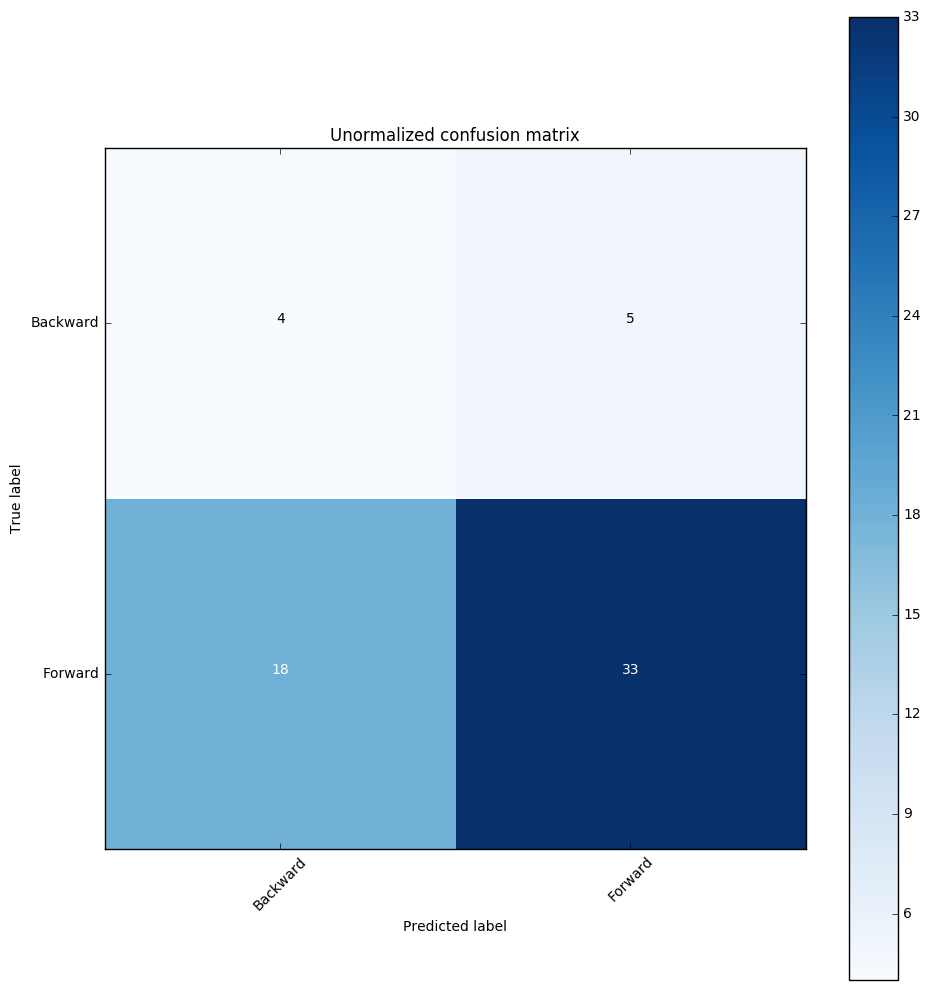

In [176]:
plot_confusion_matrix(cm, classes=['Backward', 'Forward'], normalize=False,
                      title='Unormalized confusion matrix')
plt.tight_layout()
plt.savefig('../report/figs/cm-f1-d1.pdf')